In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns
import re
import random
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from src.models.utils import milling_add_y_label_anomaly, under_over_sampler
from src.models.random_search_setup import general_params
from src.models.classifiers import (
    rf_classifier,
    xgb_classifier,
    knn_classifier,
    lr_classifier,
    sgd_classifier,
    ridge_classifier,
    svm_classifier,
    nb_classifier,
)

from sklearn.metrics import (
    roc_auc_score,
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
)

from src.models.random_search_setup import (
    rf_params,
    xgb_params,
    knn_params,
    lr_params,
    sgd_params,
    ridge_params,
    svm_params,
    nb_params,
)

%load_ext autoreload
%autoreload 2

In [2]:
path_data_folder = Path().cwd().parent.parent / 'data'
print(path_data_folder)

/home/tim/Documents/feat-store/data


In [3]:
folder_raw_data_milling = path_data_folder / "raw/milling"
folder_interim_data_milling = path_data_folder / "interim/milling"
folder_processed_data_milling = path_data_folder / "processed/milling"

In [4]:
# read in the milling features to a pandas dataframe
df_feat = pd.read_csv(
    folder_processed_data_milling / "milling.csv",
    )

df_feat.head()

,cut_id,ae_spindle__length,ae_spindle__kurtosis,ae_table__length,ae_table__kurtosis,vib_spindle__length,vib_spindle__kurtosis,vib_table__length,vib_table__kurtosis,smcdc__length,smcdc__kurtosis,smcac__length,smcac__kurtosis,cut_no,case,tool_class
0,0_0,64.0,-0.348446,64.0,-0.190215,64.0,-0.126833,64.0,2.144662,64.0,-0.256599,64.0,-1.367461,0,1,0
1,0_1,64.0,0.724161,64.0,-0.236114,64.0,0.504015,64.0,2.357173,64.0,0.384966,64.0,-1.248971,0,1,0
2,0_10,64.0,0.412827,64.0,0.031749,64.0,0.536186,64.0,2.901181,64.0,-0.167447,64.0,-1.327537,0,1,0
3,0_11,64.0,-0.087264,64.0,-0.376136,64.0,0.511172,64.0,2.578223,64.0,-0.367538,64.0,-1.441127,0,1,0
4,0_12,64.0,1.012060,64.0,1.804934,64.0,-0.108143,64.0,2.400641,64.0,-0.038878,64.0,-1.279095,0,1,0


# Putting It Together

In [5]:
def get_classifier_and_params(classifier_string):
    if classifier_string == "rf":
        return rf_classifier, rf_params

    elif classifier_string == "xgb":
        return xgb_classifier, xgb_params

    elif classifier_string == "knn":
        return knn_classifier, knn_params

    elif classifier_string == "lr":
        return lr_classifier, lr_params

    elif classifier_string == "sgd":
        return sgd_classifier, sgd_params

    elif classifier_string == "ridge":
        return ridge_classifier, ridge_params

    elif classifier_string == "svm":
        return svm_classifier, svm_params

    elif classifier_string == "nb":
        return nb_classifier, nb_params

    else:
        raise ValueError("Classifier string not recognized")

In [6]:
def calculate_scores(clf, X_test, y_test,):
    """Helper function for calculating a bunch of scores"""

    y_pred = clf.predict(X_test)

    # need decision function or probability
    # should probably remove the try-except at a later date
    try:
        y_scores = clf.decision_function(X_test)
    except:
        y_scores = clf.predict_proba(X_test)[:, 1]

    n_correct = sum(y_pred == y_test)

    # need to use decision scores, or probabilities, in roc_score
    precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)

    # calculate the precision recall curve and roc_auc curve
    # when to use ROC vs. precision-recall curves, Jason Brownlee http://bit.ly/38vEgnW
    # https://stats.stackexchange.com/questions/113326/what-is-a-good-auc-for-a-precision-recall-curve
    prauc_score = auc(recalls, precisions)
    roc_score = roc_auc_score(y_test, y_scores)

    # calculate precision, recall, f1 scores
    precision_result = precision_score(y_test, y_pred)
    recall_result = recall_score(y_test, y_pred)
    f1_result = f1_score(y_test, y_pred)


    return prauc_score, roc_score, precision_result, recall_result, f1_result, precisions, recalls, pr_thresholds, fpr, tpr, roc_thresholds, y_scores

In [7]:
Y_LABEL_COL = 'y'

# identify if there is another column you want to 
# stratify on, besides the y label
STRATIFICATION_GROUPING_COL = 'cut_no'

# list of the columns that are not features columns
# (not including the y-label column)
META_LABEL_COLS = ['cut_id', 'cut_no', 'case', 'tool_class']

RAND_SEARCH_ITER = 10

# set a seed for the parameter sampler
SAMPLER_SEED = random.randint(0, 2 ** 16)

# generate the list of parameters to sample over
train_params = list(
    ParameterSampler(
        general_params, n_iter=RAND_SEARCH_ITER, random_state=SAMPLER_SEED
    )
)[0]

uo_method = train_params['uo_method']
scaler_method = train_params['scaler_method']
imbalance_ratio = train_params['imbalance_ratio']
classifier = train_params['classifier']
print(f"classifier: {classifier}, uo_method: {uo_method}, imbalance_ratio: {imbalance_ratio}")

# get classifier and its parameters
clf_function, params = get_classifier_and_params(classifier)

# instantiate the model
clf, param_dict_raw, param_dict_named = clf_function(SAMPLER_SEED, params)
print("\n", param_dict_raw)

# load feature dataframe
df = pd.read_csv(
    folder_processed_data_milling / "milling.csv",
    )

# add y label
df = milling_add_y_label_anomaly(df)

# create the x dataframe that has the META_LABEL_COLS drop, along with the `y` column dropped
dfx = df.drop(META_LABEL_COLS + [Y_LABEL_COL], axis=1).copy()

# create the y dataframe
dfy = df[[Y_LABEL_COL]].copy()

precision_list = []
recall_list = []
fpr_list = []
tpr_list = []
prauc_list = []
rocauc_list = []

if STRATIFICATION_GROUPING_COL is not None and STRATIFICATION_GROUPING_COL is not Y_LABEL_COL:
    df_strat = df[[STRATIFICATION_GROUPING_COL, Y_LABEL_COL]].drop_duplicates()

    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # use clone to do a deep copy of model without copying attached data
    # https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html
    clone_clf = clone(clf)

    for train_index, test_index in skfolds.split(df_strat[['cut_no']], df_strat[['y']]):
        train_strat_vals = df_strat.iloc[train_index][STRATIFICATION_GROUPING_COL].values
        test_strat_vals = df_strat.iloc[test_index][STRATIFICATION_GROUPING_COL].values

        x_train = df[df[STRATIFICATION_GROUPING_COL].isin(train_strat_vals)]
        y_train = x_train[Y_LABEL_COL].values.astype(int)
        x_train = x_train.drop(META_LABEL_COLS + [Y_LABEL_COL], axis=1).values

        x_test = df[df[STRATIFICATION_GROUPING_COL].isin(train_strat_vals)]
        y_test = x_test[Y_LABEL_COL].values.astype(int)
        x_test = x_test.drop(META_LABEL_COLS + [Y_LABEL_COL], axis=1).values

        # scale the data (TO DO: create function)
        if scaler_method == "standard":
            scaler = StandardScaler()
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
        elif scaler_method == "min_max":
            scaler = MinMaxScaler()
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
        else:
            pass

        # under-over-sample the data
        x_train, y_train = under_over_sampler(
            x_train, y_train, method=uo_method, ratio=imbalance_ratio
        )

        # train model
        clone_clf.fit(x_train, y_train)

        (prauc_score, rocauc_score, precision_result, recall_result, f1_result, 
        precisions, recalls, pr_thresholds, fpr, tpr, roc_thresholds, y_scores) = calculate_scores(clone_clf, x_test, y_test)

        precision_list.append(precisions)
        recall_list.append(recalls)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        prauc_list.append(prauc_score)
        rocauc_list.append(rocauc_score)

precision_array = np.array(precision_list)
recall_array = np.array(recall_list)
fpr_array = np.array(fpr_list)
tpr_array = np.array(tpr_list)
prauc_array = np.array(prauc_list)
rocauc_array = np.array(rocauc_list)


classifier: ridge, uo_method: random_under, imbalance_ratio: 0.1

 {'alpha': 3.1182409205109263}


/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_16334/64353480.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  precision_array = np.array(precision_list)
/tmp/ipykernel_16334/

In [8]:
# r = recall_array[1][:]
# p = precision_array[1][:]

def segment_line_by_sliding_window(x, y, x_axis_n=1000):

    y_adj = [] # precision adjusted
    x_adj = [] # recall adjusted

    # break the x-axis up by moving a sliding window along it
    for j, i in enumerate(sliding_window_view(np.linspace(0, 1, x_axis_n), 2)):
        window_segment = np.where((x >= i[0]) & (x <= i[1]))[0]

        # if there are no values in the window, then
        # use the last precision value in the window
        if len(window_segment) == 0:
            x_adj.append(np.mean(i))
            y_adj.append(y_adj[-1])
        else:
            x_adj.append(np.mean(i))
            y_adj.append(np.mean(y[window_segment]))

    return np.array(x_adj), np.array(y_adj)

# r_adj, p_adj = segment_line_by_sliding_window(r, p, x_axis_n=10000)

(5, 999)


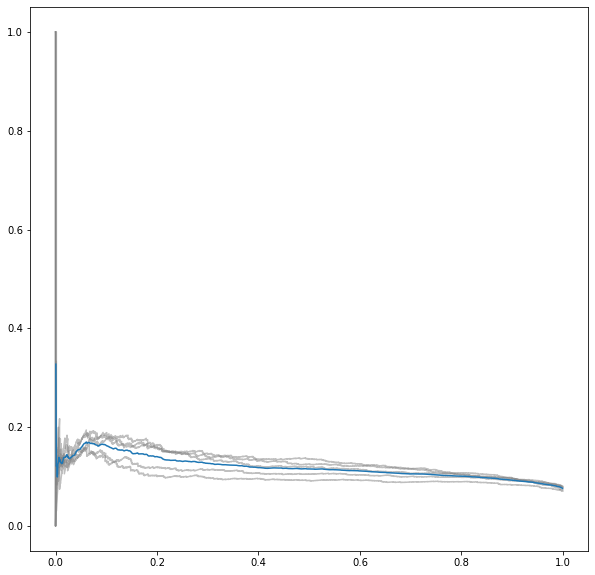

In [9]:
precisions_all_segmented = []
for p, r in zip(precision_array, recall_array):
    r_adj, p_adj = segment_line_by_sliding_window(r, p, x_axis_n=1000)
    precisions_all_segmented.append(p_adj)

precisions_all_segmented = np.array(precisions_all_segmented)
print(precisions_all_segmented.shape)


fig, axes = plt.subplots(1, 1, figsize=(10, 10))
for p, r, in zip(precision_array, recall_array):
    axes.plot(r[:], p[:], label='precision-recall curve', color='gray', alpha=0.5)

axes.plot(r_adj, precisions_all_segmented.mean(axis=0), label='mean')

https://stackoverflow.com/questions/49037902/how-to-interpolate-a-line-between-two-other-lines-in-python

In [10]:
def plot_pr_roc_curves_kfolds(precision_array, recall_array, fpr_array, tpr_array, rocauc_array, prauc_array, percent_anomalies_truth=0.073):
    # plot the precision recall curves

    # sns whitegrid context
    sns.set(style="whitegrid", context="notebook")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
    fig.tight_layout(pad=5.0)

    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

    ######
    # plot the precision recall curves
    precisions_all_segmented = []
    for p, r in zip(precision_array, recall_array):
        r_adj, p_adj = segment_line_by_sliding_window(r, p, x_axis_n=10000)
        precisions_all_segmented.append(p_adj)

    precisions_all_segmented = np.array(precisions_all_segmented)


    for i, (p, r) in enumerate(zip(precision_array, recall_array)):
        if i == np.shape(precision_array)[0] - 1:
            axes[0].plot(r[:], p[:], label='k-fold model', color='gray', alpha=0.5, linewidth=1)
        else:
            axes[0].plot(r[:], p[:], color='grey', alpha=0.5, linewidth=1)

    axes[0].plot(r_adj, precisions_all_segmented.mean(axis=0), label='Average model', color=pal[5], linewidth=2)

    axes[0].plot(
        np.array([0, 1]),
        np.array([percent_anomalies_truth, percent_anomalies_truth]),
        marker="",
        linestyle="--",
        label="No skill model",
        color="orange",
        linewidth=2, zorder=0,
    )

    axes[0].legend()
    axes[0].title.set_text("Precision-Recall Curve")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].text(
        x=-0.05,
        y=-0.3,
        s = f"PR AUC: {prauc_array.mean():.3f} (avg), {prauc_array.min():.3f} (min), {prauc_array.max():.3f} (max)",
        # fontsize=10,
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    ######
    # plot the ROC curves
    roc_all_segmented = []
    for t, f in zip(tpr_array, fpr_array):
        f_adj, t_adj = segment_line_by_sliding_window(f, t, x_axis_n=10000)
        roc_all_segmented.append(t_adj)

    roc_all_segmented = np.array(roc_all_segmented)

    for i, (t, f) in enumerate(zip(tpr_array, fpr_array)):
        if i == np.shape(tpr)[0] - 1:
            axes[1].plot(f[:], t[:], label='k-fold models', color='gray', alpha=0.5, linewidth=1)
        else:
            axes[1].plot(f[:], t[:], color='grey', alpha=0.5, linewidth=1)

    axes[1].plot(f_adj, roc_all_segmented.mean(axis=0), label='Average of k-folds', color=pal[5], linewidth=2,)

    axes[1].plot(
        np.array([0, 1]),
        np.array([0, 1]),
        marker="",
        linestyle="--",
        label="No skill",
        color="orange",
        linewidth=2,
        zorder=0,
    )

    axes[1].title.set_text("ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].text(
        x=-0.05,
        y=-0.3,
        s = f"ROC AUC: {rocauc_array.mean():.3f} (avg), {rocauc_array.min():.3f} (min), {rocauc_array.max():.3f} (max)",
        # fontsize=10,
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True, which="major")
        ax.grid(False)

    plt.show()

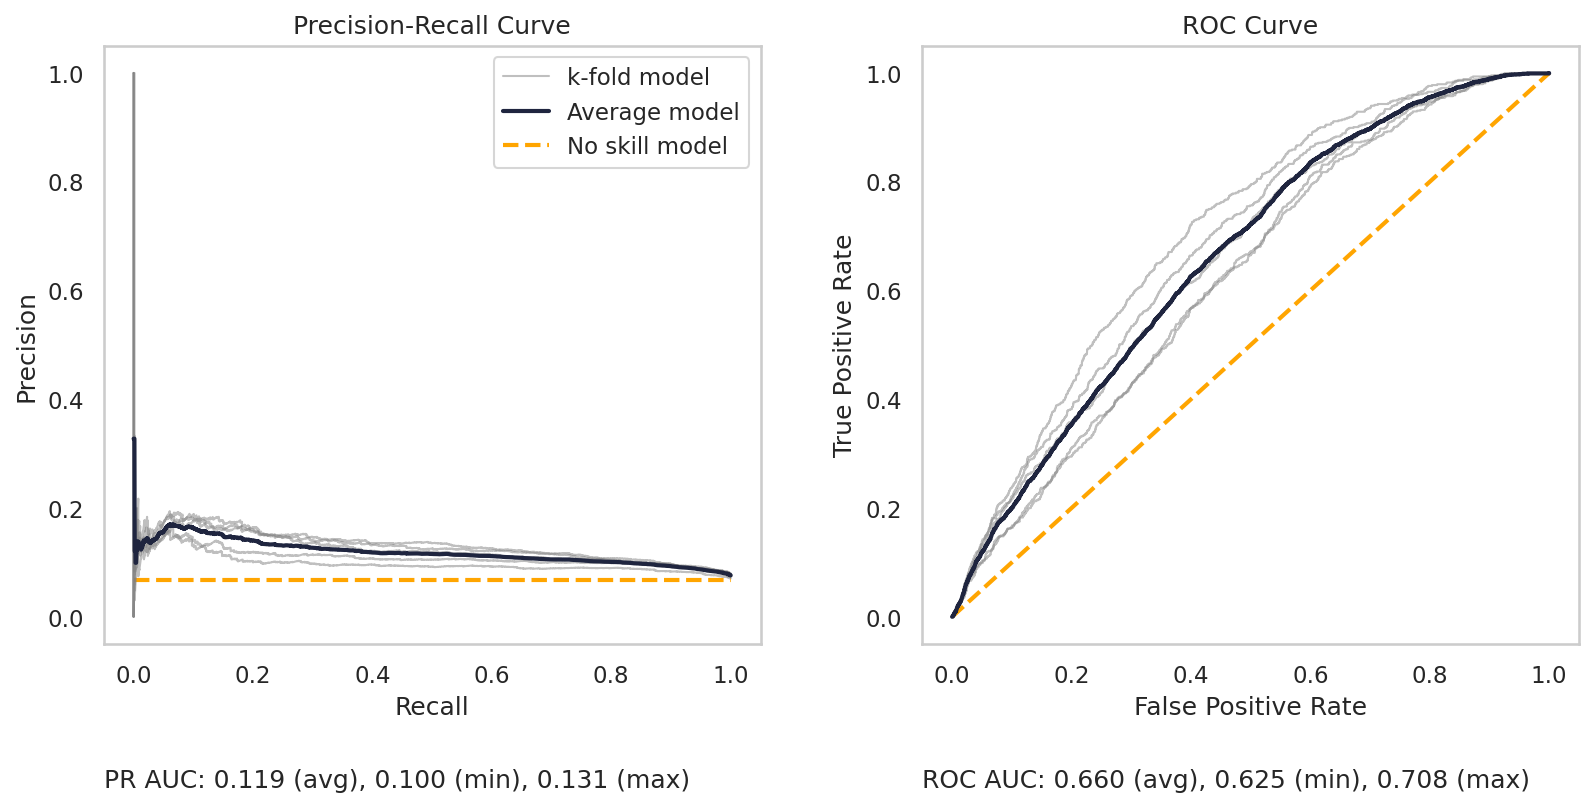

In [11]:
perct_anom = np.sum(y_test) / len(y_test)
# sns.set(font_scale=1.1, style="whitegrid")
plot_pr_roc_curves_kfolds(precision_array, recall_array, fpr_array, tpr_array, rocauc_array, prauc_array, percent_anomalies_truth=perct_anom)

In [15]:
def plot_pr_roc_curves(precisions, recalls, fpr, tpr, roc_score, prauc_score, percent_anomalies_truth=0.073):
    # plot the precision recall curves

    # sns whitegrid context
    sns.set(style="whitegrid", context="notebook")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
    fig.tight_layout(pad=5.0)

    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

    axes[0].plot(
        recalls[:],
        precisions[:],
        marker="",
        label="Best model",
        color=pal[5],
        linewidth=2,
    )

    axes[0].plot(
        np.array([0, 1]),
        np.array([percent_anomalies_truth, percent_anomalies_truth]),
        marker="",
        linestyle="--",
        label="No skill model",
        color="orange",
        linewidth=2,
    )

    axes[0].legend()
    axes[0].title.set_text("Precision-Recall Curve")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].text(
        x=-0.05,
        y=-0.3,
        s="Precision-Recall Area-Under-Curve = {:.3f}".format(prauc_score),
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    axes[1].plot(
        fpr, tpr, marker="", label="Best model", color=pal[5], linewidth=2,
    )

    axes[1].plot(
        np.array([0, 1]),
        np.array([0, 1]),
        marker="",
        linestyle="--",
        label="No skill",
        color="orange",
        linewidth=2,
    )

    axes[1].title.set_text("ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].text(
        x=-0.05,
        y=-0.3,
        s="ROC Area-Under-Curve = {:.3f}".format(roc_score),
        horizontalalignment="left",
        verticalalignment="center",
        rotation="horizontal",
        alpha=1,
    )

    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True, which="major")
        ax.grid(False)

    plt.show()

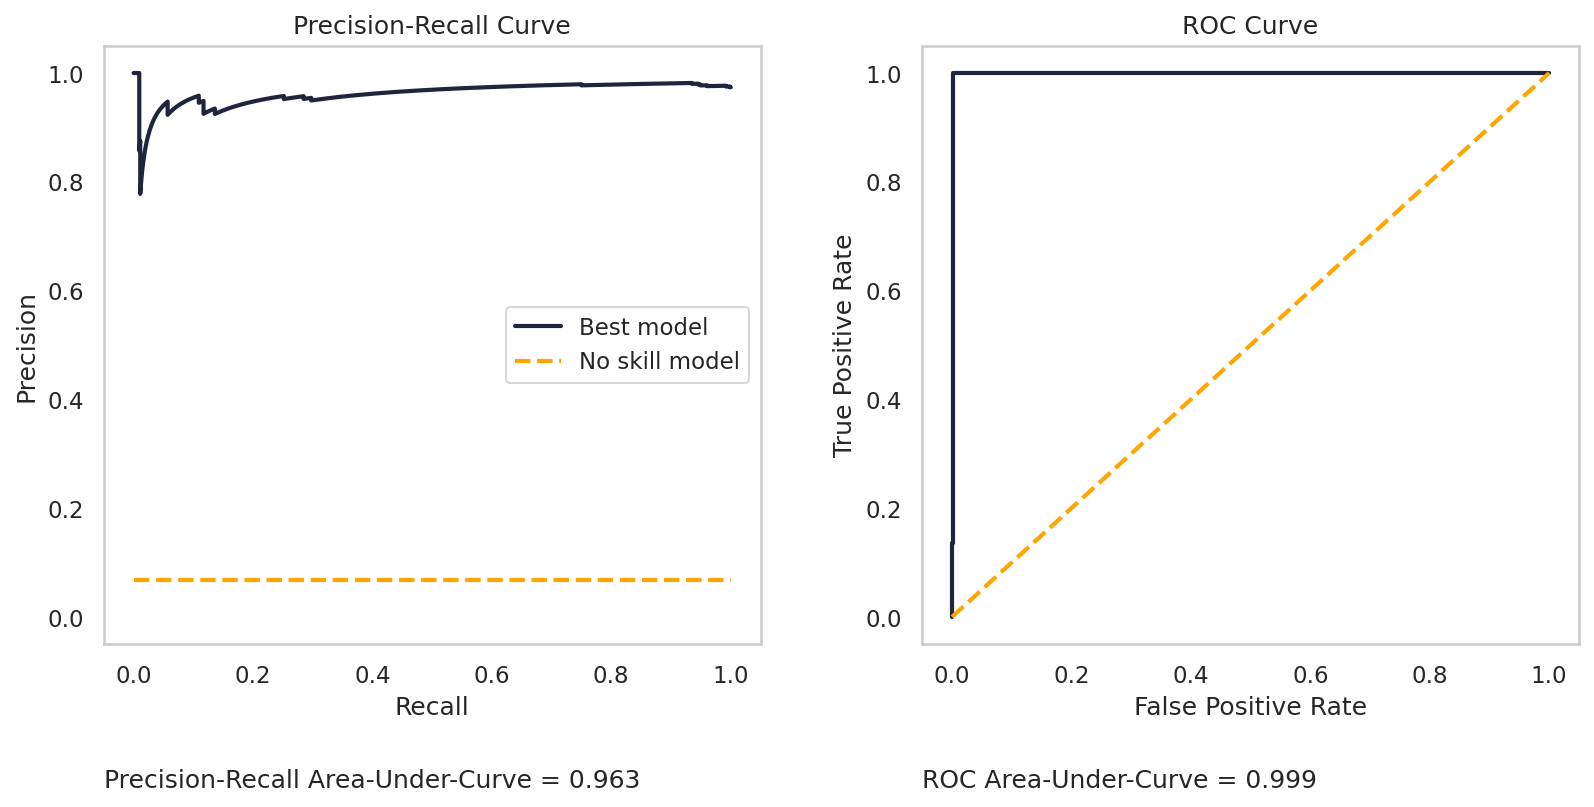

In [16]:
perct_anom = np.sum(y_test) / len(y_test)

plot_pr_roc_curves(precisions, recalls, fpr, tpr, roc_score, prauc_score, percent_anomalies_truth=perct_anom)

prauc_score = 0.122; roc_score = 0.698


Text(0, 0.5, 'True Positive Rate')

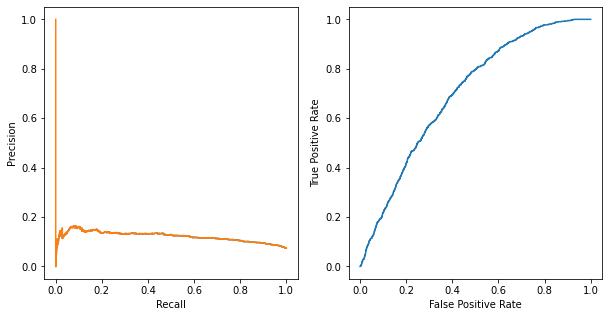

In [66]:
print(f"prauc_score = {prauc_score:0.3}; roc_score = {roc_score:.3}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(recalls[:-1], precisions[:-1])
# ax[0].plot(recalls, precisions)
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[1].plot(fpr, tpr)
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")

In [56]:
print(np.flip(precisions))
print(np.flip(recalls))

[1.         0.         0.         ... 0.07408712 0.07407842 0.07418711]
[0.         0.         0.         ... 0.99841772 0.99841772 1.        ]


In [9]:
y_scores = clone_clf.predict_proba(x_test)

In [10]:
y_scores

array([[0.77777778, 0.22222222],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.77777778, 0.22222222]])

In [11]:
y_scores.shape

(9219, 2)

In [12]:
y_pred = clone_clf.predict(x_test)

In [13]:
len(y_test)

9219

In [14]:
y_test.sum()

632

In [15]:
y_pred.sum()

1339

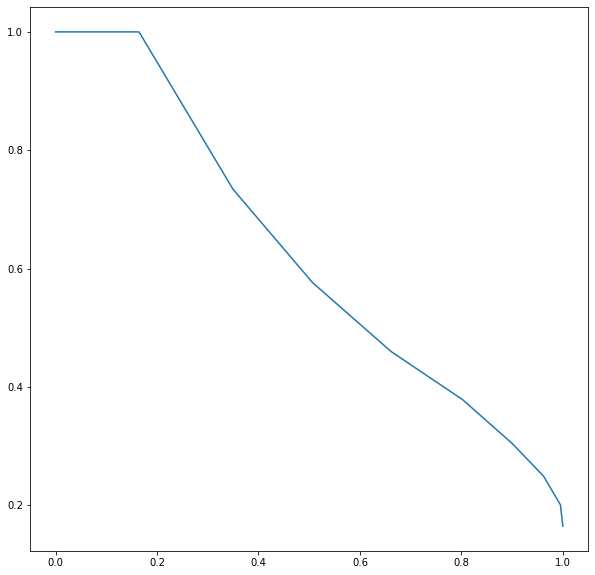

In [13]:
# function for PR-AUC and ROC curves
roc_auc_val = auc(fprs[0, :], tprs[0, :])
pr_auc_val = auc(recalls[0, :], precisions[0, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

axes[0].plot(
    recalls[0, :],
    precisions[0, :],
    marker="",
    label="Best model",
    color=pal[5],
    linewidth=2,
)

axes[0].plot(
    np.array([0, 1]),
    np.array([0.073, 0.073]),
    marker="",
    linestyle="--",
    label="No skill model",
    color="orange",
    linewidth=2,
)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text(
    x=-0.05,
    y=-0.3,
    s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(
    fprs[0, :], tprs[0, :], marker="", label="Best model", color=pal[5], linewidth=2,
)

axes[1].plot(
    np.array([0, 1]),
    np.array([0, 1]),
    marker="",
    linestyle="--",
    label="No skill",
    color="orange",
    linewidth=2,
)

axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(
    x=-0.05,
    y=-0.3,
    s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True, which="major")
    ax.grid(False)

plt.show()

0.15059180423895235

In [25]:
train_params

{'uo_method': 'random_over',
 'scaler_method': 'standard',
 'imbalance_ratio': 0.8,
 'classifier': <function src.models.classifiers.gaussian_classifier(sampler_seed, gaussian_params)>}

In [56]:
test_strat_vals

array([116,  11, 125, 126, 134, 135, 136, 139,  13, 140, 152, 155, 164,
         1,  21,  24,  29,  44,  45,  47,  48,  51,  52,  57,  68,   6,
        75,  80,  81,  83,  86,  92,  93])

In [47]:
df_strat

,cut_no,y
0,0,0
70,100,0
136,101,0
202,102,0
268,103,0
...,...,...
11256,96,0
11318,97,0
11380,98,0
11434,99,0


In [41]:
train_strat_vals

array([  0, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159,  15, 160, 161, 162, 163, 164, 165, 166,  16,  18,  19,   1,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,   2,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,   3,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,   4,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,   5,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,   6,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         7,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,   8,  90,
        91,  92,  93,  95,  96,  97,  98,  99,   9])

In [42]:
test_strat_vals

array([  0, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159,  15, 160, 161, 162, 163, 164, 165, 166,  16,  18,  19,   1,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,   2,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,   3,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,   4,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,   5,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,   6,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         7,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,   8,  90,
        91,  92,  93,  95,  96,  97,  98,  99,   9])

In [15]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, cut_no_val  in skfolds.split(df[['cut_no']], df[['y']]):
    # print(cut_no_train)
    print(cut_no_val)

[  4   8   9  10  11  12  26  27  34  37  41  47  49  50  55  57  68  69
  72  75  76  92 101 110 111 114 115 119 123 142 148 159 162]
[ 13  14  23  25  30  35  51  60  63  67  70  73  78  81  85  91  95  96
  99 102 116 125 127 129 131 133 135 137 139 140 143 146 149]
[  0   1   6   7  15  19  21  24  33  36  42  46  53  59  64  84  88  89
  90  97  98 103 106 109 117 124 134 136 141 154 155 160 163]
[  2   3   5  16  17  20  31  32  48  52  54  56  62  65  66  74  80  83
  86  93  94 100 120 121 122 126 128 151 152 153 156 161 164]
[ 18  22  28  29  38  39  40  43  44  45  58  61  71  77  79  82  87 104
 105 107 108 112 113 118 130 132 138 144 145 147 150 157 158]


In [ ]:
class TrainAnomalyClassifier:
    """
    Class for setting up and training an anomaly detection classifier.
    Utilizes a random search.
    """

In [16]:
cut_no_val

array([ 18,  22,  28,  29,  38,  39,  40,  43,  44,  45,  58,  61,  71,
        77,  79,  82,  87, 104, 105, 107, 108, 112, 113, 118, 130, 132,
       138, 144, 145, 147, 150, 157, 158])

In [19]:
df.iloc[cut_no_val]

,cut_no,y
1161,116,0
1461,11,0
1887,125,0
1953,126,0
2567,134,0
2642,135,0
2717,136,0
2942,139,0
3017,13,0
3087,140,1


In [ ]:
def k_fold_other_column()